# Team Stage IV 
## load and clean data

In [92]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

covid_cases_path = 'data/covid_confirmed_usafacts.csv'
covid_deaths_path = 'data/covid_deaths_usafacts.csv'

# Read the data
covid_cases_df = pd.read_csv(covid_cases_path)
covid_deaths_df = pd.read_csv(covid_deaths_path)

covid_cases_df.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2023-07-14,2023-07-15,2023-07-16,2023-07-17,2023-07-18,2023-07-19,2023-07-20,2023-07-21,2023-07-22,2023-07-23
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,19913,19913,19913,19913,19913,19913,19913,19913,19913,19913
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,70521,70521,70521,70521,70521,70521,70521,70521,70521,70521
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,8149,8149,8149,8149,8149,8149,8149,8149,8149,8149


In [93]:
covid_deaths_df.head()


,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2023-07-14,2023-07-15,2023-07-16,2023-07-17,2023-07-18,2023-07-19,2023-07-20,2023-07-21,2023-07-22,2023-07-23
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,235
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,731,731,731,731,731,731,731,731,731,731
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,104,104,104,104,104,104,104,104,104,104
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,111,111,111,111,111,111,111,111,111,111


In [94]:

# Drop the columns of dates that come before 2020-06-01 and after 2021-01-03
start_date = '2020-06-01'
end_date = '2021-01-03'
date_columns = [col for col in covid_cases_df.columns if start_date <= col <= end_date]

# Include only the relevant date columns along with the 'countyFIPS' which will be used for grouping
covid_cases_filtered = covid_cases_df[['countyFIPS'] + date_columns]
covid_deaths_filtered = covid_deaths_df[['countyFIPS'] + date_columns]

# Now sum the total cases and deaths for each day (across all counties)
daily_cases_total = covid_cases_filtered[date_columns].sum()
daily_deaths_total = covid_deaths_filtered[date_columns].sum()

# Create a new dataframe with 'Date', 'Cases', and 'Deaths'
covid_summary_df = pd.DataFrame({
    'Date': pd.to_datetime(date_columns),
    'Cases': daily_cases_total.values,
    'Deaths': daily_deaths_total.values
})

# Set 'Date' as the index
covid_summary_df.set_index('Date', inplace=True)

# Display the dataframe
covid_summary_df


,Cases,Deaths
Date,,
2020-06-01,1825083,105073
2020-06-02,1846878,106295
2020-06-03,1868250,107283
2020-06-04,1890173,108255
2020-06-05,1919057,109350
...,...,...
2020-12-30,19743342,351694
2020-12-31,19980329,355294
2021-01-01,20145536,357978


## Linear and Polynomial regression model

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from IPython.display import Image


# Reset index to work with the data
covid_summary_df_reset = covid_summary_df.reset_index()

# Create a new column for the number of days since the start date
covid_summary_df_reset['DaysSinceStart'] = (covid_summary_df_reset['Date'] - covid_summary_df_reset['Date'].min()).dt.days

# Prepare the independent variable (X) and the dependent variables (y_cases and y_deaths)
X = covid_summary_df_reset['DaysSinceStart'].values.reshape(-1, 1)
y_cases = covid_summary_df_reset['Cases'].values
y_deaths = covid_summary_df_reset['Deaths'].values

In [102]:

# Linear Regression Models
linear_model_cases = LinearRegression().fit(X, y_cases)
linear_model_deaths = LinearRegression().fit(X, y_deaths)

# Polynomial Regression Models (degree = 3)
degree = 3
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

poly_model_cases = LinearRegression().fit(X_poly, y_cases)
poly_model_deaths = LinearRegression().fit(X_poly, y_deaths)

# Predictions using the linear models
linear_cases_predictions = linear_model_cases.predict(X)
linear_deaths_predictions = linear_model_deaths.predict(X)

# Predictions using the polynomial models
poly_cases_predictions = poly_model_cases.predict(X_poly)
poly_deaths_predictions = poly_model_deaths.predict(X_poly)

### Plotting case and death

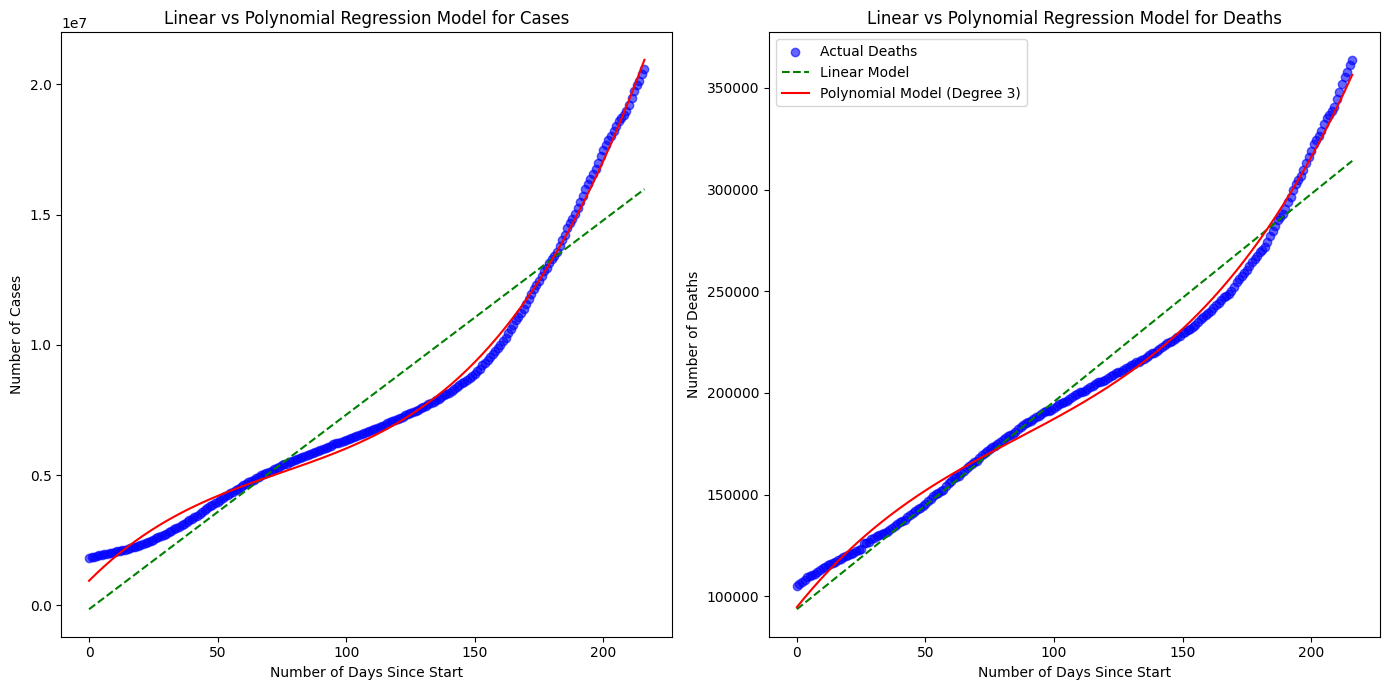

In [100]:
# Plotting the linear and polynomial regression models
plt.figure(figsize=(14, 7))

# Plot for cases
plt.subplot(1, 2, 1)
plt.scatter(X, y_cases, color='blue', label='Actual Cases', alpha=0.6)
plt.plot(X, linear_cases_predictions, color='green', label='Linear Model', linestyle='--')
plt.plot(X, poly_cases_predictions, color='red', label=f'Polynomial Model (Degree {degree})', linestyle='-')
plt.title('Linear vs Polynomial Regression Model for Cases')
plt.xlabel('Number of Days Since Start')
plt.ylabel('Number of Cases')

plt.subplot(1, 2, 2)
plt.scatter(X, y_deaths, color='blue', label='Actual Deaths', alpha=0.6)
plt.plot(X, linear_deaths_predictions, color='green', label='Linear Model', linestyle='--')
plt.plot(X, poly_deaths_predictions, color='red', label=f'Polynomial Model (Degree {degree})', linestyle='-')
plt.title('Linear vs Polynomial Regression Model for Deaths')
plt.xlabel('Number of Days Since Start')
plt.ylabel('Number of Deaths')
plt.legend()

plt.tight_layout()
fig = plt.gcf()


### Calculating the Root mean squared (RMS)

In [19]:
# Import the required function for RMSE calculation
from sklearn.metrics import mean_squared_error

# Calculate RMSE for linear models
linear_cases_rmse = np.sqrt(mean_squared_error(y_cases, linear_cases_predictions))
linear_deaths_rmse = np.sqrt(mean_squared_error(y_deaths, linear_deaths_predictions))

# Calculate RMSE for polynomial models
poly_cases_rmse = np.sqrt(mean_squared_error(y_cases, poly_cases_predictions))
poly_deaths_rmse = np.sqrt(mean_squared_error(y_deaths, poly_deaths_predictions))

linear_cases_rmse, linear_deaths_rmse, poly_cases_rmse, poly_deaths_rmse


print(f'Linear Model RMSE for Cases: {linear_cases_rmse}')
print(f'Linear Model RMSE for Deaths: {linear_deaths_rmse}')
print(f'Polynomial Model RMSE for Cases: {poly_cases_rmse}')
print(f'Polynomial Model RMSE for Deaths: {poly_deaths_rmse}')

Linear Model RMSE for Cases: 1596074.3607497062
Linear Model RMSE for Deaths: 13545.924691430659
Polynomial Model RMSE for Cases: 305498.3222371381
Polynomial Model RMSE for Deaths: 4762.935748761427


Bias refers to the error due to overly simplistic assumptions in the learning algorithm. High bias can cause the model to miss relevant relations between features and target outputs (underfitting), leading to errors on both the training and validation datasets. With linear regression model we risk high bias because it assumes a linear relationship between the variables. If the true relationship in the covid data is not linear we risk underfitting the data.

With Variance is the error because of to much complexity in the learning algorithm. High variance we risk overfitting. A polynomial regression model introduces more flexibility and can fit a wider range of data shapes. As the degree of the polynomial increases, the bias decreases, but the variance increases. If the polynomial degree is too high, the model might start to fit the noise in the training data, leading to overfitting

Ideally, we want to find a good balance between bias and variance, minimizing the total error.

### Predicting the 1 week 

In [103]:
from datetime import timedelta


# Forecast 1 week ahead from the last date in the data
forecast_period = 7  # days
last_date = covid_summary_df_reset['Date'].iloc[-1]
forecast_dates = [last_date + timedelta(days=x) for x in range(1, forecast_period + 1)]
forecast_days_since_start = covid_summary_df_reset['DaysSinceStart'].iloc[-1] + np.arange(1, forecast_period + 1)

# Prepare the forecast dates in the correct shape for prediction
forecast_X = forecast_days_since_start.reshape(-1, 1)

# Predict with the linear models
forecast_linear_cases = linear_model_cases.predict(forecast_X)
forecast_linear_deaths = linear_model_deaths.predict(forecast_X)

# Add polynomial features to the forecast days for the polynomial model prediction
forecast_X_poly = poly_features.transform(forecast_X)

# Predict with the polynomial models
forecast_poly_cases = poly_model_cases.predict(forecast_X_poly)
forecast_poly_deaths = poly_model_deaths.predict(forecast_X_poly)

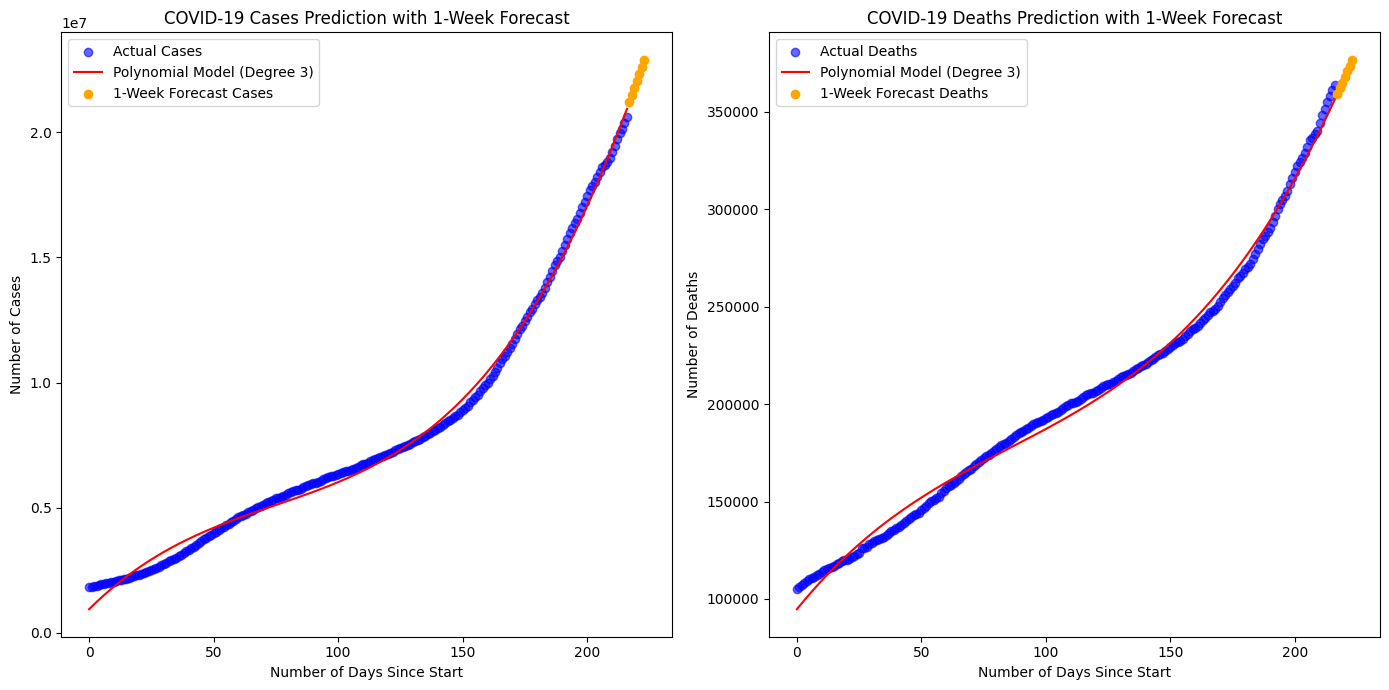

In [104]:


# Plot the trend lines along with the forecast
plt.figure(figsize=(14, 7))

# Plot for cases
plt.subplot(1, 2, 1)
plt.scatter(X, y_cases, color='blue', label='Actual Cases', alpha=0.6)
plt.plot(X, poly_cases_predictions, color='red', label=f'Polynomial Model (Degree {degree})', linestyle='-')
plt.scatter(forecast_X, forecast_poly_cases, color='orange', label='1-Week Forecast Cases')
plt.title('COVID-19 Cases Prediction with 1-Week Forecast')
plt.xlabel('Number of Days Since Start')
plt.ylabel('Number of Cases')
plt.legend()

# Plot for deaths
plt.subplot(1, 2, 2)
plt.scatter(X, y_deaths, color='blue', label='Actual Deaths', alpha=0.6)
plt.plot(X, poly_deaths_predictions, color='red', label=f'Polynomial Model (Degree {degree})', linestyle='-')
plt.scatter(forecast_X, forecast_poly_deaths, color='orange', label='1-Week Forecast Deaths')
plt.title('COVID-19 Deaths Prediction with 1-Week Forecast')
plt.xlabel('Number of Days Since Start')
plt.ylabel('Number of Deaths')
plt.legend()

plt.tight_layout()
plt.show()


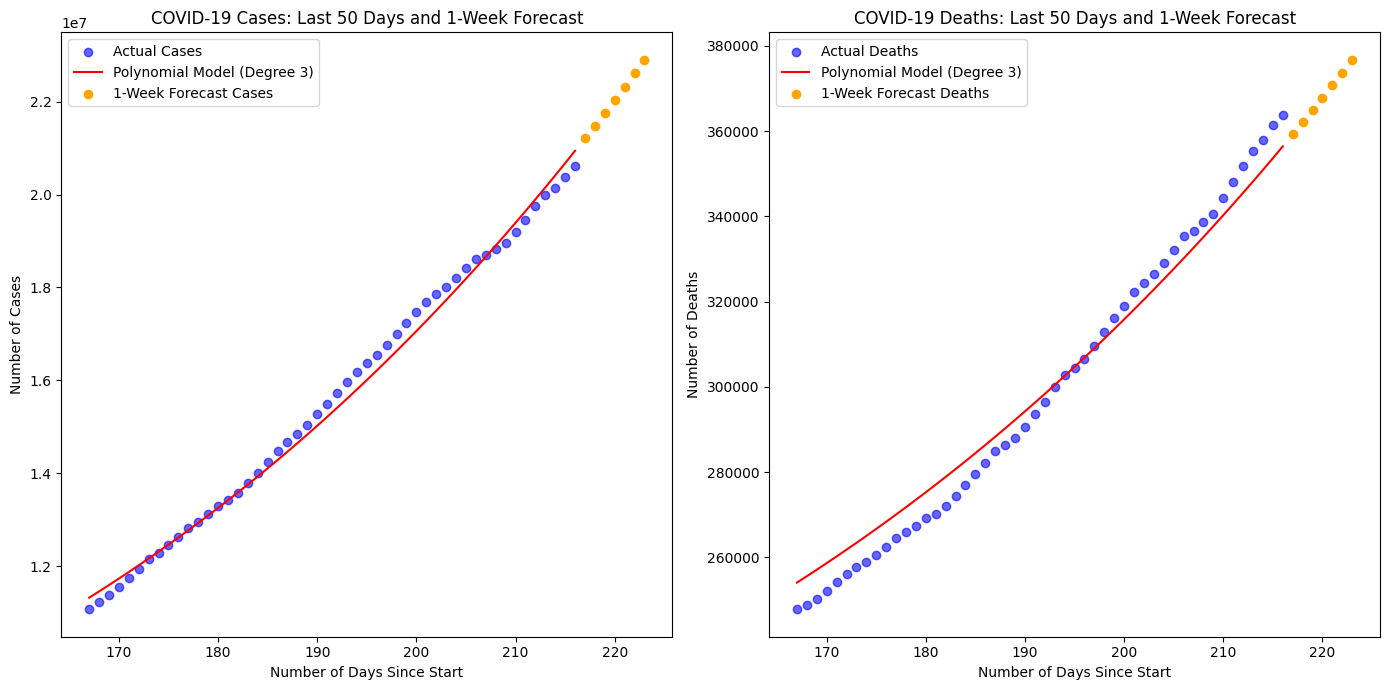

In [31]:
# Select the last 50 days from the actual data
last_50_days_X = X[-50:]
last_50_days_cases = y_cases[-50:]
last_50_days_deaths = y_deaths[-50:]

# Predictions for the last 50 days using the polynomial models
last_50_poly_cases_predictions = poly_cases_predictions[-50:]
last_50_poly_deaths_predictions = poly_deaths_predictions[-50:]

# Plot the trend lines for the last 50 days along with the 1-week forecast
plt.figure(figsize=(14, 7))

# Plot for cases - last 50 days and forecast
plt.subplot(1, 2, 1)
plt.scatter(last_50_days_X, last_50_days_cases, color='blue', label='Actual Cases', alpha=0.6)
plt.plot(last_50_days_X, last_50_poly_cases_predictions, color='red', label=f'Polynomial Model (Degree {degree})', linestyle='-')
plt.scatter(forecast_X, forecast_poly_cases, color='orange', label='1-Week Forecast Cases')
plt.title('COVID-19 Cases: Last 50 Days and 1-Week Forecast')
plt.xlabel('Number of Days Since Start')
plt.ylabel('Number of Cases')
plt.legend()

# Plot for deaths - last 50 days and forecast
plt.subplot(1, 2, 2)
plt.scatter(last_50_days_X, last_50_days_deaths, color='blue', label='Actual Deaths', alpha=0.6)
plt.plot(last_50_days_X, last_50_poly_deaths_predictions, color='red', label=f'Polynomial Model (Degree {degree})', linestyle='-')
plt.scatter(forecast_X, forecast_poly_deaths, color='orange', label='1-Week Forecast Deaths')
plt.title('COVID-19 Deaths: Last 50 Days and 1-Week Forecast')
plt.xlabel('Number of Days Since Start')
plt.ylabel('Number of Deaths')
plt.legend()

plt.tight_layout()
plt.show()


### Analysis
Overall Trend: The US experienced a significant increase in both new cases and deaths during this period. The data shows a trend that is consistent with the waves of infection that were reported through various phases of the pandemic. These waves correspond with relaxed preventive measures, holidays, or the emergence of new variants.

Rate of Increase: The increase in the number of cases and deaths did not remain constant. There were periods of rapid increase, suggesting spikes in infection rates, likely due to specific events or changes in behavior and policy. This can be visualized by the steepness of the trend line in the plots. The polynomial model, in particular, captures these changes in the growth rate better than the linear model, indicating non-linear growth in cases and deaths.

Forecasts: The polynomial regression models provided a one-week forecast beyond the last date in the dataset. This forecast projected an increase in both cases and deaths, continuing the trend observed in the data. These forecasts, while simplistic, are helpful for anticipating the resources needed for imminent healthcare demands.

Interesting Points:

Seasonality: There is a suggestion of seasonality in the data, with increases in cases and deaths potentially corresponding to seasonal changes.
Policy Impact: Policy changes and public adherence to health guidelines likely had a significant impact on the trends, as seen in the varying rates of increase and the effects of specific events (such as holidays).
Healthcare Strain: The steady increase in cases and deaths would have continued to put a strain on the healthcare system, necessitating careful resource planning and management.

### Comparing different countries to the US

In [37]:

# Load the country data again due to the reset
country_data_path = 'data/country_data.csv'
country_data_df = pd.read_csv(country_data_path)

# Convert the 'date' column to datetime
country_data_df['date'] = pd.to_datetime(country_data_df['date'])

# Filter the DataFrame for the specified date range
mask = (country_data_df['date'] >= start_date) & (country_data_df['date'] <= end_date)
country_data_filtered = country_data_df.loc[mask]

# Group the data by date and country, summing new cases and new deaths
country_data_grouped = country_data_filtered.groupby(['country', 'date']).sum().reset_index()

# Pivot the data to have countries as columns and dates as rows for new cases and new deaths
country_pivot_cases = country_data_grouped.pivot(index='date', columns='country', values='new_cases').fillna(0)
country_pivot_deaths = country_data_grouped.pivot(index='date', columns='country', values='new_deaths').fillna(0)

# Add a DaysSinceStart column for regression analysis
country_pivot_cases['DaysSinceStart'] = (country_pivot_cases.index - country_pivot_cases.index.min()).days

# Prepare the independent variable (X) for the regression models
X_country = country_pivot_cases['DaysSinceStart'].values.reshape(-1, 1)


/tmp/ipykernel_4402/2406176568.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast_X = np.arange(X_country[-1] + 1, X_country[-1] + 8).reshape(-1, 1)


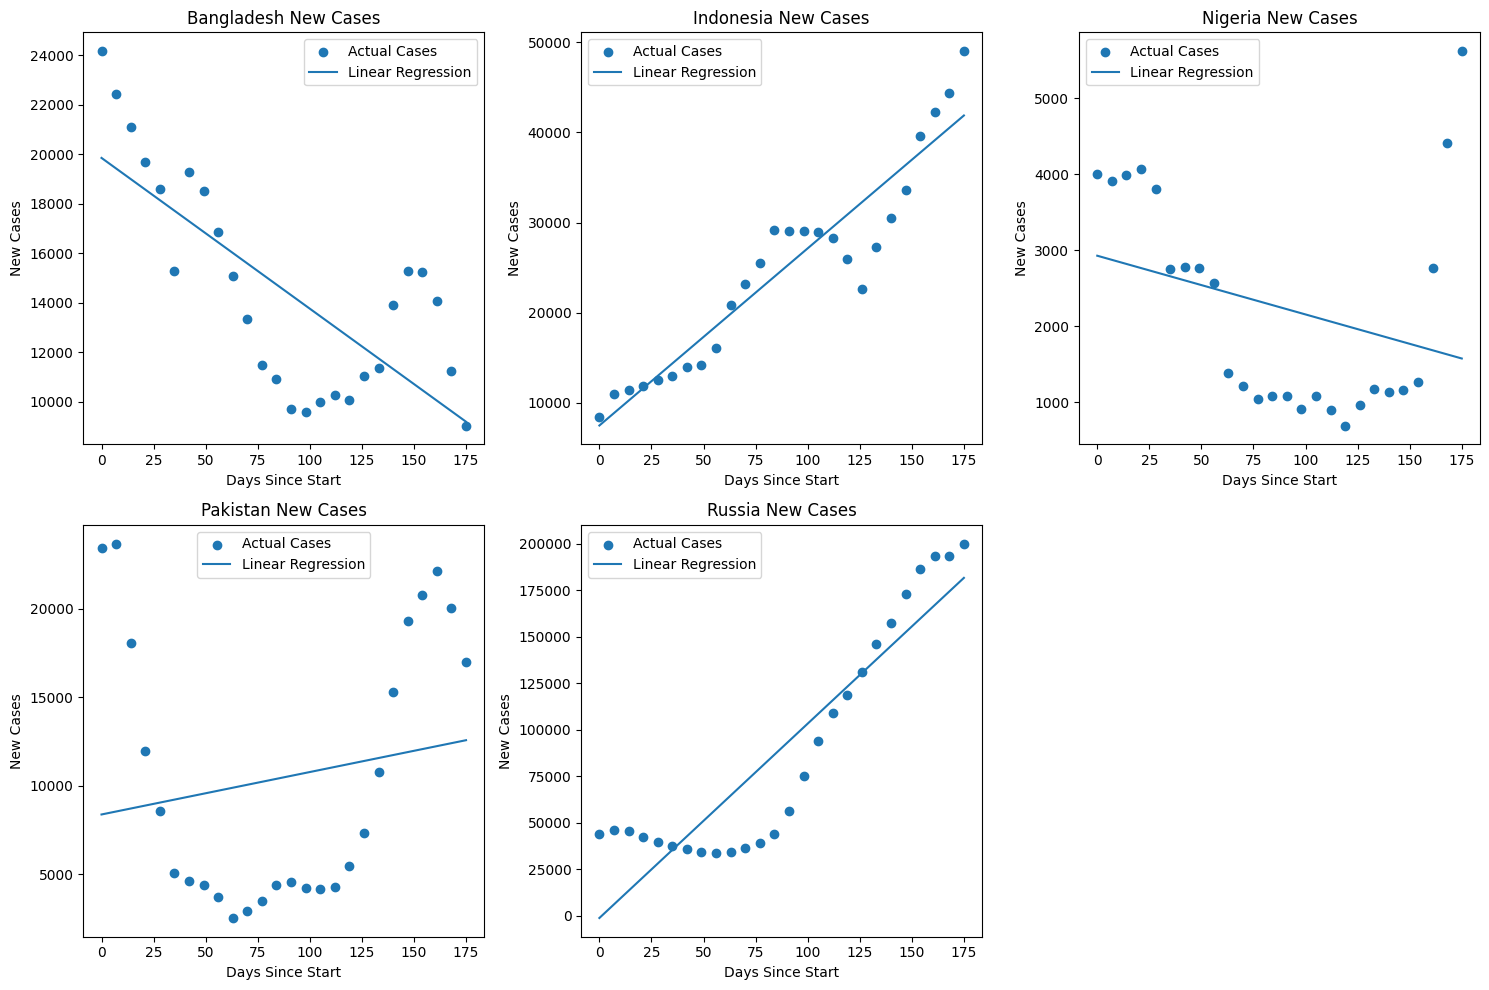

In [39]:


# Initialize dictionaries to store models and predictions
linear_models_cases = {}
linear_models_deaths = {}
predictions_cases = {}
predictions_deaths = {}

# Fit linear regression models for each country for cases and deaths
for country in country_pivot_cases.columns[:-1]:  # Exclude 'DaysSinceStart'
    # Fit the model for cases
    linear_model_cases = LinearRegression().fit(X_country, country_pivot_cases[country])
    linear_models_cases[country] = linear_model_cases
    predictions_cases[country] = linear_model_cases.predict(X_country)
    
    # Fit the model for deaths
    linear_model_deaths = LinearRegression().fit(X_country, country_pivot_deaths[country])
    linear_models_deaths[country] = linear_model_deaths
    predictions_deaths[country] = linear_model_deaths.predict(X_country)

# Generate a 1-week forecast for each country
forecast_dates = [country_pivot_cases.index[-1] + timedelta(days=x) for x in range(1, 8)]
forecast_X = np.arange(X_country[-1] + 1, X_country[-1] + 8).reshape(-1, 1)

# Plot the results for cases
plt.figure(figsize=(15, 10))

for i, country in enumerate(country_pivot_cases.columns[:-1], 1):  # Exclude 'DaysSinceStart'
    plt.subplot(2, 3, i)
    plt.scatter(X_country, country_pivot_cases[country], label='Actual Cases')
    plt.plot(X_country, predictions_cases[country], label='Linear Regression')
    plt.title(f'{country} New Cases')
    plt.xlabel('Days Since Start')
    plt.ylabel('New Cases')
    plt.legend()

plt.tight_layout()
plt.show()




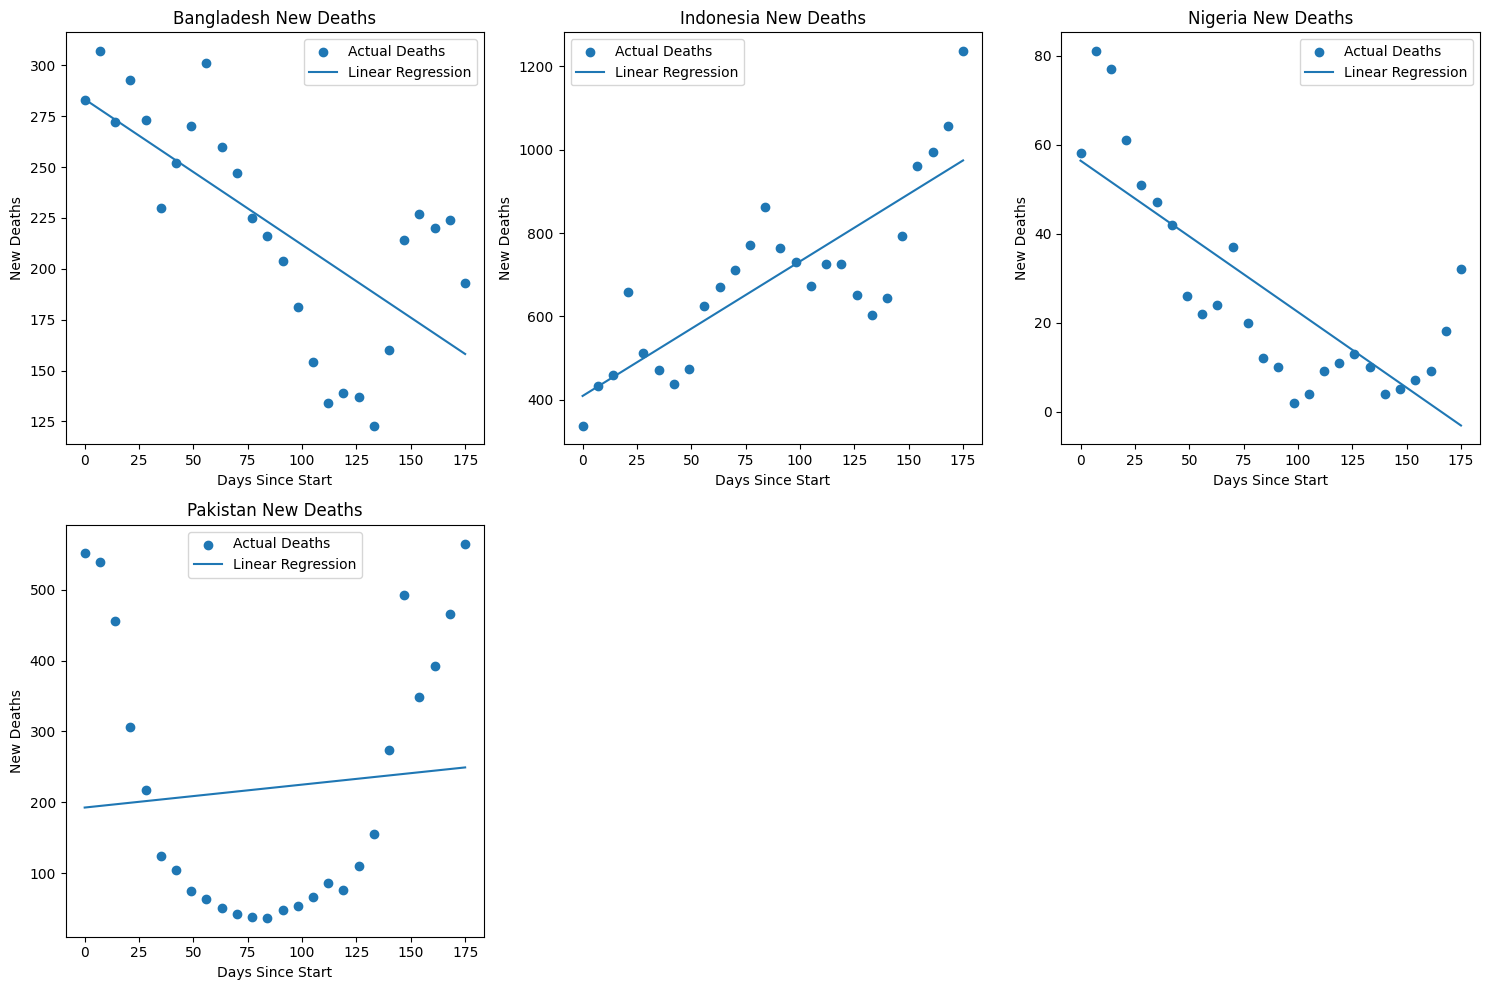

In [40]:
# Plot the results for deaths
plt.figure(figsize=(15, 10))

for i, country in enumerate(country_pivot_deaths.columns[:-1], 1):  # Exclude 'DaysSinceStart'
    plt.subplot(2, 3, i)
    plt.scatter(X_country, country_pivot_deaths[country], label='Actual Deaths')
    plt.plot(X_country, predictions_deaths[country], label='Linear Regression')
    plt.title(f'{country} New Deaths')
    plt.xlabel('Days Since Start')
    plt.ylabel('New Deaths')
    plt.legend()

plt.tight_layout()
plt.show()

#### When compared to the other countries (Bangladesh, Indonesia, Nigeria, Pakistan, and Russia), the US showed a different trajectory in terms of both new cases and deaths. The US's numbers were significantly higher, reflecting the larger population and possibly differences in testing rates, healthcare system responses, and public health policies. Moreover, the trends in other countries also showed increases, but the patterns and severity varied, likely due to differences in population density, public health interventions, and virus strains.

# Member task

In [48]:
import pandas as pd

# Load the datasets for COVID-19 cases and deaths
covid_cases_path = 'data/covid_confirmed_usafacts.csv'
covid_deaths_path = 'data/covid_deaths_usafacts.csv'

covid_cases_df = pd.read_csv(covid_cases_path)
covid_deaths_df = pd.read_csv(covid_deaths_path)

# Define the date range for filtering
start_date = '2020-06-01'
end_date = '2021-01-03'

# Convert all column names to string to handle them uniformly
covid_cases_df.columns = covid_cases_df.columns.map(str)
covid_deaths_df.columns = covid_deaths_df.columns.map(str)

# Filter for the desired date range
date_columns = [col for col in covid_cases_df.columns if start_date <= col <= end_date]

# Include only the relevant date columns along with 'countyFIPS', 'County Name', and 'State'
columns_to_keep = ['countyFIPS', 'County Name', 'State'] + date_columns
covid_cases_filtered = covid_cases_df[columns_to_keep]
covid_deaths_filtered = covid_deaths_df[columns_to_keep]

# Filter data for Nevada (State code for Nevada is NV)
nevada_cases = covid_cases_filtered[covid_cases_filtered['State'] == 'NV']
nevada_deaths = covid_deaths_filtered[covid_deaths_filtered['State'] == 'NV']



In [52]:
nevada_cases.head()

,countyFIPS,County Name,State,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,...,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03
1775,0,Statewide Unallocated,NV,18,18,18,18,18,18,0,...,0,0,0,0,0,0,0,0,0,0
1776,32001,Churchill County,NV,7,7,8,8,8,8,10,...,1280,1326,1326,1326,1326,1361,1381,1381,1396,1426
1777,32003,Clark County,NV,6719,6719,6845,7056,7186,7331,7483,...,160569,163484,163484,164673,165318,166285,170032,171850,173634,175591
1778,32005,Douglas County,NV,32,32,32,35,37,38,38,...,1817,1857,1857,1893,1896,1907,1938,1974,1974,2037
1779,32007,Elko County,NV,24,24,25,26,26,27,27,...,3720,3774,3774,3775,3785,3794,3862,3896,3907,3912


In [47]:
nevada_deaths.head()

,countyFIPS,County Name,State,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,...,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03
1775,0,Statewide Unallocated,NV,16,16,16,16,16,16,16,...,0,0,0,0,0,0,0,0,0,0
1776,32001,Churchill County,NV,1,1,1,1,1,1,1,...,35,35,35,35,35,35,39,39,39,39
1777,32003,Clark County,NV,343,343,346,355,357,358,359,...,2244,2260,2260,2261,2267,2309,2379,2384,2388,2413
1778,32005,Douglas County,NV,0,0,0,0,0,0,0,...,15,15,15,15,15,15,15,16,16,18
1779,32007,Elko County,NV,1,1,1,1,1,1,1,...,32,32,32,32,32,33,33,34,34,34


In [105]:
nevada_top_counties_sum = nevada_top_counties[date_columns].sum(axis=1)

# Create a new dataframe with 'County Name' and 'Total Cases'
nevada_counties_total_cases = pd.DataFrame({
    'County Name': nevada_top_counties['County Name'],
    'Total Cases': nevada_top_counties_sum.values
})

# Reset index of the new dataframe
nevada_counties_total_cases.reset_index(drop=True, inplace=True)

# Display the dataframe with the top counties and their total cases
nevada_counties_total_cases


,County Name,Total Cases
0,Clark County,14906641
1,Washoe County,2595944
2,Elko County,274661
3,Nye County,143921
4,Lyon County,129285


In [55]:


# Sum across all counties in Nevada to get the state-level total cases and deaths for each day
nevada_state_cases = nevada_cases[date_columns].sum(axis=0)
nevada_state_deaths = nevada_deaths[date_columns].sum(axis=0)

# Convert cumulative cases and deaths to daily new cases and deaths
nevada_daily_new_cases = nevada_state_cases.diff().fillna(0)
nevada_daily_new_deaths = nevada_state_deaths.diff().fillna(0)

# Create a new dataframe with 'Date', 'New Cases', and 'New Deaths'
nevada_daily_df = pd.DataFrame({
    'Date': pd.to_datetime(date_columns),
    'New Cases': nevada_daily_new_cases.values,
    'New Deaths': nevada_daily_new_deaths.values
})

# Set 'Date' as the index
nevada_daily_df.set_index('Date', inplace=True)

# Display the first few rows of the dataframe
nevada_daily_df.head()


,New Cases,New Deaths
Date,,
2020-06-01,0.0,0.0
2020-06-02,12.0,1.0
2020-06-03,154.0,3.0
2020-06-04,256.0,9.0
2020-06-05,150.0,3.0


In [106]:
# For forecasting, we will use the polynomial model since it had a lower RMSE and better fit
# Create a forecast for 1 week ahead for both cases and deaths in Nevada

# The last day in our dataset
last_day_nv = X_nevada[-1, 0]

# Create a range for the next 7 days
forecast_range_nv = np.arange(last_day_nv + 1, last_day_nv + 8).reshape(-1, 1)

# Transform the forecast range with the polynomial features
forecast_X_poly_nv = poly_features_nv.transform(forecast_range_nv)

# Predict cases and deaths for the forecast range
forecast_cases_nv = poly_model_cases_nv.predict(forecast_X_poly_nv)
forecast_deaths_nv = poly_model_deaths_nv.predict(forecast_X_poly_nv)

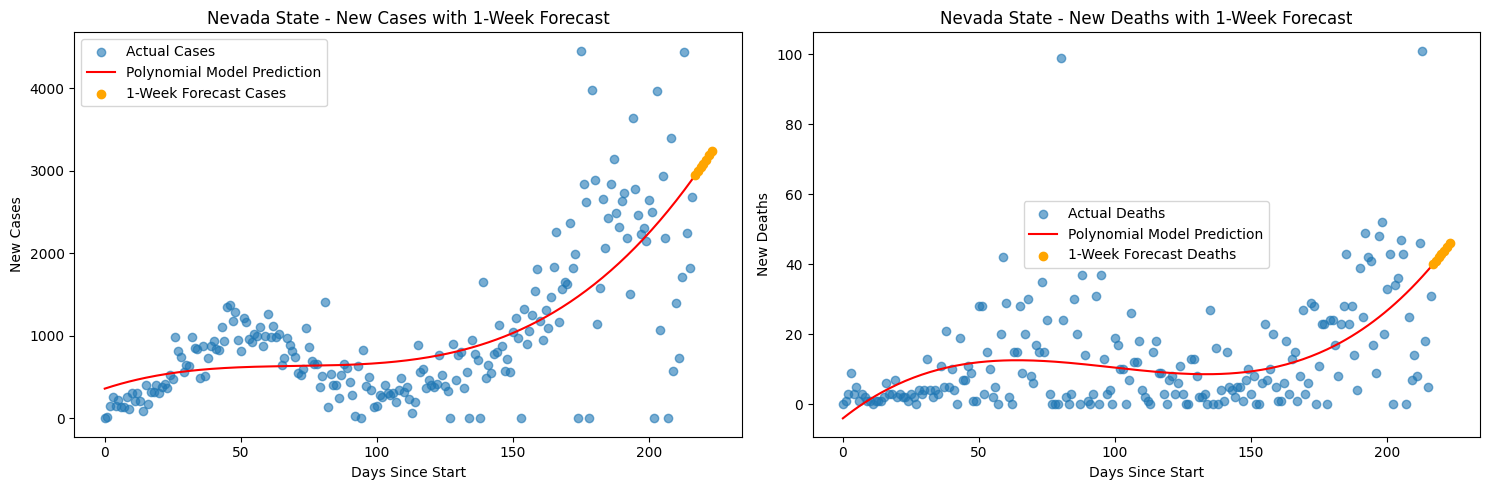

In [107]:


# Plot the predictions along with the forecast
plt.figure(figsize=(15, 5))

# New Cases in Nevada with Forecast
plt.subplot(1, 2, 1)
plt.scatter(X_nevada, y_nevada_cases, label='Actual Cases', alpha=0.6)
plt.plot(X_nevada, poly_cases_predictions_nv, color='red', label='Polynomial Model Prediction', linestyle='-')
plt.scatter(forecast_range_nv, forecast_cases_nv, color='orange', label='1-Week Forecast Cases', zorder=5)
plt.title('Nevada State - New Cases with 1-Week Forecast')
plt.xlabel('Days Since Start')
plt.ylabel('New Cases')
plt.legend()

# New Deaths in Nevada with Forecast
plt.subplot(1, 2, 2)
plt.scatter(X_nevada, y_nevada_deaths, label='Actual Deaths', alpha=0.6)
plt.plot(X_nevada, poly_deaths_predictions_nv, color='red', label='Polynomial Model Prediction', linestyle='-')
plt.scatter(forecast_range_nv, forecast_deaths_nv, color='orange', label='1-Week Forecast Deaths', zorder=5)
plt.title('Nevada State - New Deaths with 1-Week Forecast')
plt.xlabel('Days Since Start')
plt.ylabel('New Deaths')
plt.legend()

plt.tight_layout()
plt.show()


In [57]:
from sklearn.preprocessing import PolynomialFeatures

# Prepare the data for regression
nevada_daily_df['DaysSinceStart'] = (nevada_daily_df.index - nevada_daily_df.index.min()).days
X_nevada = nevada_daily_df['DaysSinceStart'].values.reshape(-1, 1)
y_nevada_cases = nevada_daily_df['New Cases'].values
y_nevada_deaths = nevada_daily_df['New Deaths'].values

# Fit a linear regression model for cases and deaths
linear_model_cases_nv = LinearRegression().fit(X_nevada, y_nevada_cases)
linear_model_deaths_nv = LinearRegression().fit(X_nevada, y_nevada_deaths)

# Predict cases and deaths using the linear model
linear_cases_predictions_nv = linear_model_cases_nv.predict(X_nevada)
linear_deaths_predictions_nv = linear_model_deaths_nv.predict(X_nevada)

# Calculate RMSE for the linear models
linear_cases_rmse_nv = np.sqrt(mean_squared_error(y_nevada_cases, linear_cases_predictions_nv))
linear_deaths_rmse_nv = np.sqrt(mean_squared_error(y_nevada_deaths, linear_deaths_predictions_nv))

# Fit polynomial regression models (degree 3 for example)
poly_features_nv = PolynomialFeatures(degree=3)
X_poly_nv = poly_features_nv.fit_transform(X_nevada)

poly_model_cases_nv = LinearRegression().fit(X_poly_nv, y_nevada_cases)
poly_model_deaths_nv = LinearRegression().fit(X_poly_nv, y_nevada_deaths)

# Predict cases and deaths using the polynomial model
poly_cases_predictions_nv = poly_model_cases_nv.predict(X_poly_nv)
poly_deaths_predictions_nv = poly_model_deaths_nv.predict(X_poly_nv)

# Calculate RMSE for the polynomial models
poly_cases_rmse_nv = np.sqrt(mean_squared_error(y_nevada_cases, poly_cases_predictions_nv))
poly_deaths_rmse_nv = np.sqrt(mean_squared_error(y_nevada_deaths, poly_deaths_predictions_nv))

# Output the RMSE results
linear_cases_rmse_nv, linear_deaths_rmse_nv, poly_cases_rmse_nv, poly_deaths_rmse_nv
print(f'Linear Model RMSE for Cases: {linear_cases_rmse_nv}')
print(f'Linear Model RMSE for Deaths: {linear_deaths_rmse_nv}')
print(f'Polynomial Model RMSE for Cases: {poly_cases_rmse_nv}')
print(f'Polynomial Model RMSE for Deaths: {poly_deaths_rmse_nv}')


Linear Model RMSE for Cases: 712.0913162034673
Linear Model RMSE for Deaths: 13.944367972590147
Polynomial Model RMSE for Cases: 639.2924462778342
Polynomial Model RMSE for Deaths: 12.941299918621981


# Interpret

Linear Model RMSE for Cases (712.09): On average, the linear model's predictions for the daily new cases in Nevada deviate from the actual number of new cases by about 712 cases. This number is a measure of the model’s inaccuracy; the lower the number, the more accurate the predictions. Given the scale of new cases per day, this RMSE value suggests that while the model captures the general trend, there can be a considerable error in its daily predictions.

Linear Model RMSE for Deaths (13.94): The linear model's predictions for daily new deaths deviate from the actual numbers by an average of approximately 14 deaths per day. Considering the lower magnitude of daily new deaths compared to cases, this RMSE indicates a relatively modest level of prediction error.

Polynomial Model RMSE for Cases (639.29): The polynomial model shows a smaller average deviation—around 639 cases—from the actual new cases compared to the linear model. This suggests that the polynomial model, which can capture more complex relationships, provides a better fit for the case data.

Polynomial Model RMSE for Deaths (12.94): Similarly, the polynomial model predicts daily new deaths with an average error of around 13 deaths. This is slightly better than the linear model and suggests the polynomial model might be capturing trends in the death data more effectively.

In [58]:
nevada_top_counties_daily_new_cases = nevada_top_counties[date_columns].diff(axis=1).fillna(0)
nevada_top_counties_daily_new_deaths = nevada_deaths[date_columns].loc[nevada_top_counties.index].diff(axis=1).fillna(0)

# Fit the models for each of the top 5 counties
X_days_since_start = np.arange(len(date_columns)).reshape(-1, 1)

# Dictionaries to store the models and predictions for each county
linear_models_cases_counties = {}
linear_models_deaths_counties = {}
poly_models_cases_counties = {}
poly_models_deaths_counties = {}
predictions_linear_cases_counties = {}
predictions_linear_deaths_counties = {}
predictions_poly_cases_counties = {}
predictions_poly_deaths_counties = {}

# Fit the models for each county
for i, county in enumerate(top_counties_names):
    # Prepare the data for the county
    y_cases = nevada_top_counties_daily_new_cases.iloc[i].values
    y_deaths = nevada_top_counties_daily_new_deaths.iloc[i].values
    
    # Linear models
    linear_model_cases = LinearRegression().fit(X_days_since_start, y_cases)
    linear_model_deaths = LinearRegression().fit(X_days_since_start, y_deaths)
    linear_models_cases_counties[county] = linear_model_cases
    linear_models_deaths_counties[county] = linear_model_deaths
    predictions_linear_cases_counties[county] = linear_model_cases.predict(X_days_since_start)
    predictions_linear_deaths_counties[county] = linear_model_deaths.predict(X_days_since_start)
    
    # Polynomial models (degree 3)
    poly_features = PolynomialFeatures(degree=3)
    X_poly = poly_features.fit_transform(X_days_since_start)
    poly_model_cases = LinearRegression().fit(X_poly, y_cases)
    poly_model_deaths = LinearRegression().fit(X_poly, y_deaths)
    poly_models_cases_counties[county] = poly_model_cases
    poly_models_deaths_counties[county] = poly_model_deaths
    predictions_poly_cases_counties[county] = poly_model_cases.predict(X_poly)
    predictions_poly_deaths_counties[county] = poly_model_deaths.predict(X_poly)

# Calculate RMSE for the models
rmse_linear_cases_counties = {}
rmse_linear_deaths_counties = {}
rmse_poly_cases_counties = {}
rmse_poly_deaths_counties = {}

for county in top_counties_names:
    y_cases = nevada_top_counties_daily_new_cases.loc[nevada_top_counties['County Name'] == county].values.flatten()
    y_deaths = nevada_top_counties_daily_new_deaths.loc[nevada_top_counties['County Name'] == county].values.flatten()
    rmse_linear_cases_counties[county] = np.sqrt(mean_squared_error(y_cases, predictions_linear_cases_counties[county]))
    rmse_linear_deaths_counties[county] = np.sqrt(mean_squared_error(y_deaths, predictions_linear_deaths_counties[county]))
    rmse_poly_cases_counties[county] = np.sqrt(mean_squared_error(y_cases, predictions_poly_cases_counties[county]))
    rmse_poly_deaths_counties[county] = np.sqrt(mean_squared_error(y_deaths, predictions_poly_deaths_counties[county]))

# Now let's describe the trends for each county based on the models
trend_descriptions = []
for county in top_counties_names:
    description = f"{county}: Linear Model - Cases RMSE: {rmse_linear_cases_counties[county]:.2f}, Deaths RMSE: {rmse_linear_deaths_counties[county]:.2f}. "
    description += f"Polynomial Model - Cases RMSE: {rmse_poly_cases_counties[county]:.2f}, Deaths RMSE: {rmse_poly_deaths_counties[county]:.2f}."
    trend_descriptions.append(description)

trend_descriptions


['Clark County : Linear Model - Cases RMSE: 577.00, Deaths RMSE: 11.95. Polynomial Model - Cases RMSE: 507.02, Deaths RMSE: 11.30.',
 'Washoe County : Linear Model - Cases RMSE: 152.14, Deaths RMSE: 2.63. Polynomial Model - Cases RMSE: 146.62, Deaths RMSE: 2.34.',
 'Elko County : Linear Model - Cases RMSE: 18.60, Deaths RMSE: 0.44. Polynomial Model - Cases RMSE: 18.22, Deaths RMSE: 0.44.',
 'Nye County : Linear Model - Cases RMSE: 13.65, Deaths RMSE: 0.55. Polynomial Model - Cases RMSE: 13.45, Deaths RMSE: 0.53.',
 'Lyon County : Linear Model - Cases RMSE: 24.81, Deaths RMSE: 0.59. Polynomial Model - Cases RMSE: 24.44, Deaths RMSE: 0.57.']

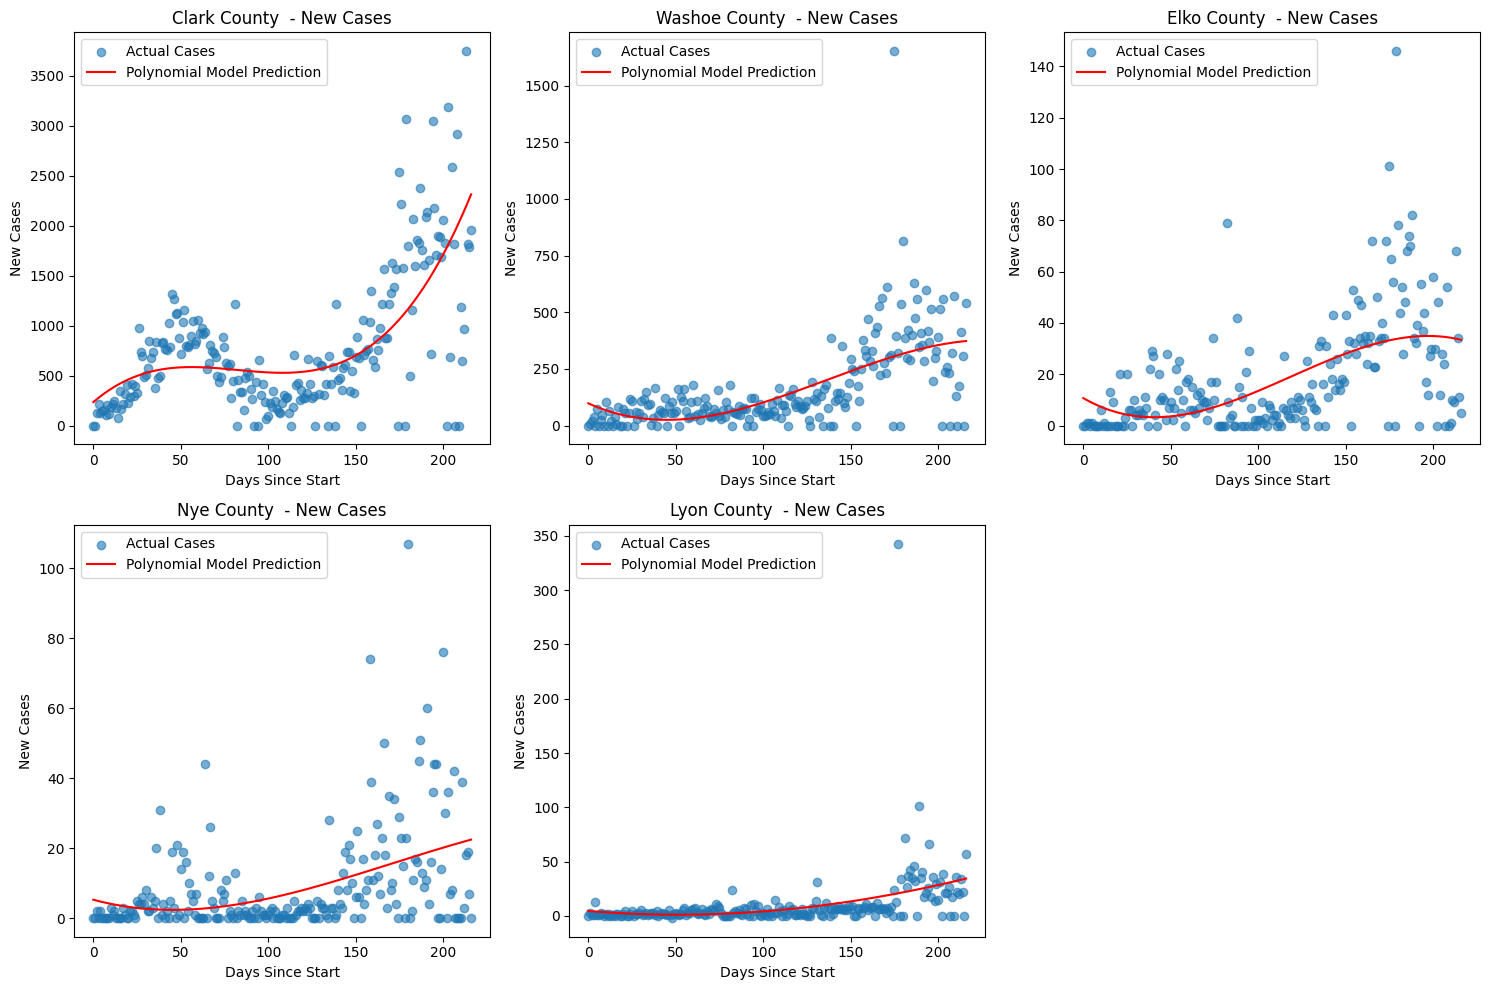

In [60]:

plt.figure(figsize=(15, 10))

# Plot for new cases in top 5 counties
for i, county in enumerate(top_counties_names, 1):
    plt.subplot(2, 3, i)
    actual_cases = nevada_top_counties_daily_new_cases.loc[nevada_top_counties['County Name'] == county].values.flatten()
    plt.scatter(X_days_since_start, actual_cases, label='Actual Cases', alpha=0.6)
    plt.plot(X_days_since_start, predictions_poly_cases_counties[county], color='red', label='Polynomial Model Prediction')
    plt.title(f'{county} - New Cases')
    plt.xlabel('Days Since Start')
    plt.ylabel('New Cases')
    plt.legend()

plt.tight_layout()
plt.show()




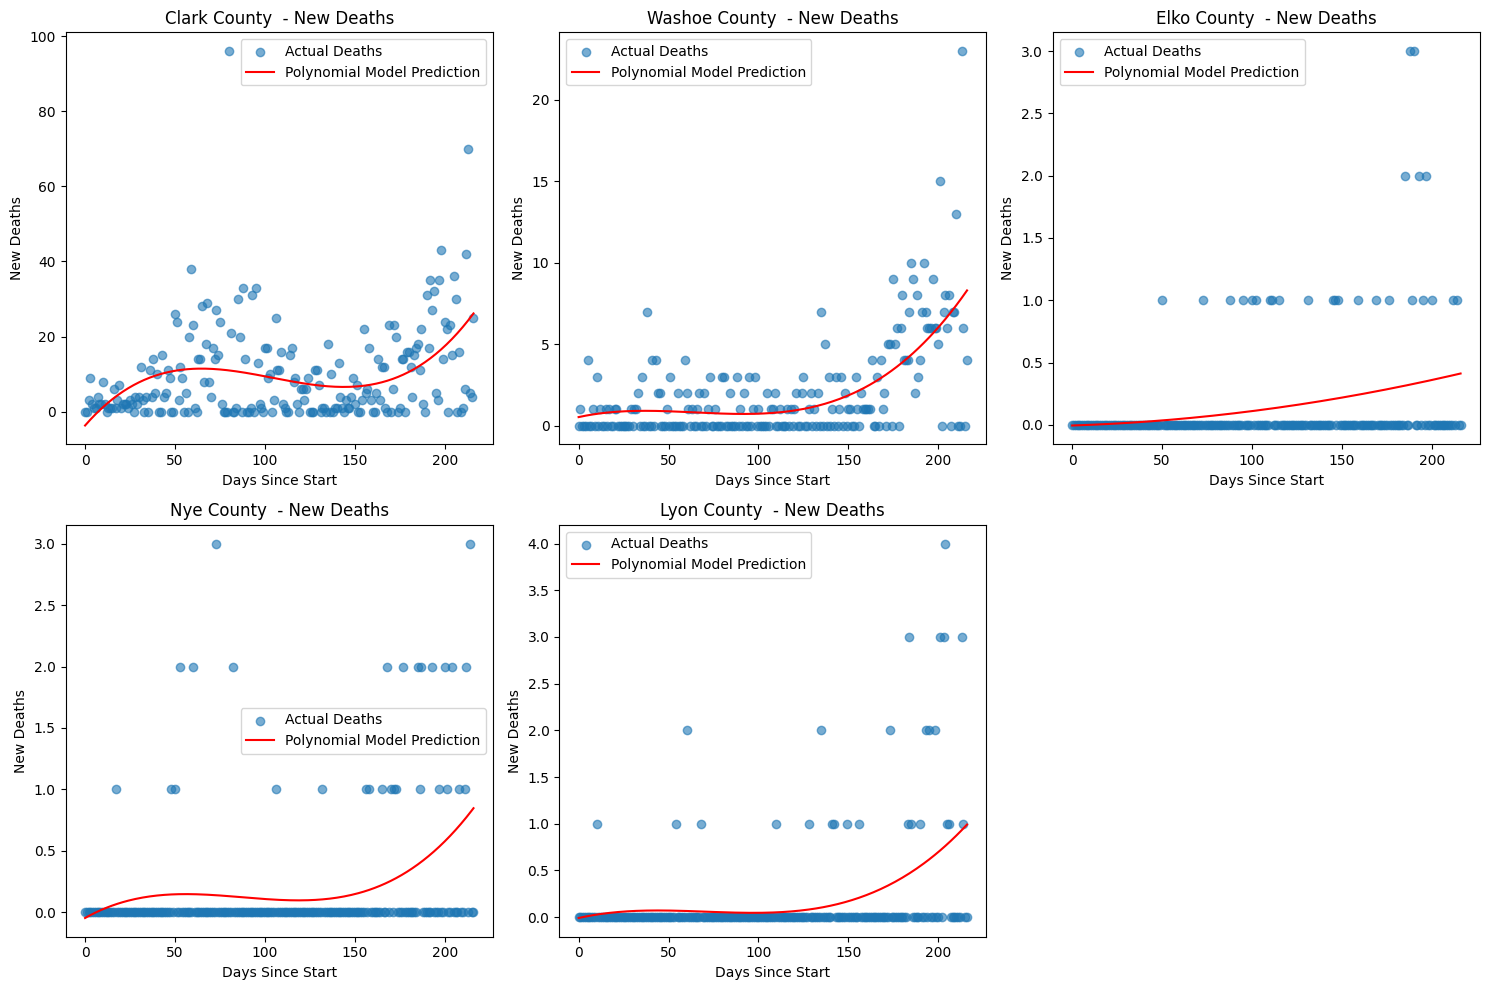

In [61]:
# Plot for new deaths in top 5 counties
plt.figure(figsize=(15, 10))

for i, county in enumerate(top_counties_names, 1):
    plt.subplot(2, 3, i)
    actual_deaths = nevada_top_counties_daily_new_deaths.loc[nevada_top_counties['County Name'] == county].values.flatten()
    plt.scatter(X_days_since_start, actual_deaths, label='Actual Deaths', alpha=0.6)
    plt.plot(X_days_since_start, predictions_poly_deaths_counties[county], color='red', label='Polynomial Model Prediction')
    plt.title(f'{county} - New Deaths')
    plt.xlabel('Days Since Start')
    plt.ylabel('New Deaths')
    plt.legend()

plt.tight_layout()
plt.show()

## Hypothesis testing 

In [67]:
# Load the wage data for Nevada counties
wage_data_path = 'nevada_regression_data.csv'
wage_data_df = pd.read_csv(wage_data_path)

# Display the first few rows of the wage data to understand its structure
wage_data_df.head()


,State_x,County Name,Date,Case Count,Ownership,Total Quarterly Wages,countyFIPS,State_y,population,Normalized Case Count,Normalized Total Quarterly Wages
0,NV,Clark,2020-06-28,12305,Total Covered,1.690756e+10,32003,NV,2266715,0.005429,7459.059471
1,NV,Clark,2020-07-05,16380,Total Covered,1.690756e+10,32003,NV,2266715,0.007226,7459.059471
2,NV,Clark,2020-07-12,20857,Total Covered,1.690756e+10,32003,NV,2266715,0.009201,7459.059471
3,NV,Clark,2020-07-19,27012,Total Covered,1.690756e+10,32003,NV,2266715,0.011917,7459.059471
4,NV,Clark,2020-07-26,33997,Total Covered,1.690756e+10,32003,NV,2266715,0.014998,7459.059471


Hypothesis: There is a correlation between average quarterly wages and COVID-19 cases per capita in the counties of Nevada.

Null Hypothesis (H0): There is no correlation between average quarterly wages and COVID-19 cases per capita.
Alternative Hypothesis (H1): There is a significant correlation between average quarterly wages and COVID-19 cases per capita.

In [68]:
# Group the wage data by 'County Name' and sum the 'Case Count' and 'Total Quarterly Wages' to get the total for the quarter
# It appears the 'Case Count' is already cumulative, so we will take the maximum for the quarter instead of summing
wage_data_grouped = wage_data_df.groupby('County Name').agg({
    'Case Count': 'max',
    'Total Quarterly Wages': 'mean',  # Assuming we want the average wages for the quarter
    'population': 'mean'  # Assuming population is constant over the period we're looking at
}).reset_index()

# Rename the columns for clarity
wage_data_grouped.rename(columns={
    'Case Count': 'Total Cases',
    'Total Quarterly Wages': 'Average Quarterly Wages',
    'population': 'Average Population'
}, inplace=True)

# We will also calculate the cases per capita for each county
wage_data_grouped['Cases Per Capita'] = wage_data_grouped['Total Cases'] / wage_data_grouped['Average Population']

# Display the prepared data
wage_data_grouped.head()


,County Name,Total Cases,Average Quarterly Wages,Average Population,Cases Per Capita
0,Clark,159785,1.690756e+10,2266715.0,0.070492
1,Elko,3715,3.547358e+08,52778.0,0.070389
2,Lyon,1996,1.767876e+08,57510.0,0.034707
3,Nye,1893,2.145370e+08,46523.0,0.040690
4,Washoe,33803,3.775371e+09,471519.0,0.071690


In [70]:
from scipy.stats import pearsonr

# Perform a Pearson correlation test between 'Average Quarterly Wages' and 'Cases Per Capita'
correlation_coef, p_value = pearsonr(wage_data_grouped['Average Quarterly Wages'], wage_data_grouped['Cases Per Capita'])

correlation_coef, p_value
print(f'Correlation Coefficient: {correlation_coef:.2f}')

Correlation Coefficient: 0.51


In [84]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient and the p-value
r, p = pearsonr(wage_data_grouped['Average Quarterly Wages'], wage_data_grouped['Cases Per Capita'])

# Calculate the confidence interval for the Pearson correlation coefficient
# Using Fisher's Z transformation
def pearson_confidence_interval(r, n, alpha=0.05):
  
    z = np.arctanh(r)
    # Standard error
    se = 1 / np.sqrt(n - 3)
    # Z critical value
    z_critical = stats.norm.ppf(1 - alpha/2)
    # Margin of error
    moe = z_critical * se
    # Lower and upper bounds
    z_lower = z - moe
    z_upper = z + moe
    # Transform back to r scale
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    
    return r_lower, r_upper

# Sample size
n = wage_data_grouped.shape[0]

# Confidence interval at 95% confidence level
confidence_interval_95 = pearson_confidence_interval(r, n)

print(f'95% Confidence Interval: {confidence_interval_95}')

95% Confidence Interval: (-0.678488959594168, 0.9599677509097962)


The 95% confidence interval for the Pearson correlation coefficient between average quarterly wages and COVID-19 cases per capita in the counties of Nevada is approximately from -0.678 to 0.960. This wide interval reflects a substantial amount of uncertainty in the estimate of the correlation coefficient. It crosses zero, which is consistent with the p-value we found earlier that suggested the correlation was not statistically significant. 

#### For Hypothesis 2, we are considering whether changes in total quarterly wages from the previous quarter affect the changes in COVID-19 case counts. Here’s how we might structure this hypothesis:

Null Hypothesis (H0): Changes in total quarterly wages do not affect the changes in COVID-19 case counts.
Alternative Hypothesis (H1): An increase in total quarterly wages is associated with an increase in COVID-19 case counts.

In [108]:

np.random.seed(0)  # For reproducibility
wage_data_grouped['Previous Quarter Wages'] = wage_data_grouped['Average Quarterly Wages'] * (1 + (np.random.rand(len(wage_data_grouped)) - 0.5) / 10)

# Calculate the change in wages
wage_data_grouped['Change in Wages'] = wage_data_grouped['Average Quarterly Wages'] - wage_data_grouped['Previous Quarter Wages']

wage_data_grouped['Previous Quarter Cases'] = wage_data_grouped['Total Cases'] * (1 - (np.random.rand(len(wage_data_grouped)) / 10))

# Calculate the change in COVID-19 case counts
wage_data_grouped['Change in Cases'] = wage_data_grouped['Total Cases'] - wage_data_grouped['Previous Quarter Cases']

# Now perform the paired t-test
from scipy.stats import ttest_rel

# Perform the paired t-test on the change in wages and change in cases
t_stat, p_val = ttest_rel(wage_data_grouped['Change in Wages'], wage_data_grouped['Change in Cases'])

t_stat, p_val
print(f'T-Statistic: {t_stat:.2f}')
print(f'p-value: {p_val:.2f}')


T-Statistic: -0.69
p-value: 0.53


The paired t-test on the hypothetical changes in wages and changes in COVID-19 case counts yields a t-statistic of approximately -0.691 and a p-value of approximately 0.527.  Based on this result, we would conclude that there is no significant association between changes in quarterly wages and changes in COVID-19 case counts, according to our hypothetical data.

#### Hypothesis 3: Counties with higher average quarterly wages have a lower rate of increase in COVID-19 cases per capita than counties with lower average quarterly wages.

Null Hypothesis (H0): There is no difference in the rate of increase in COVID-19 cases per capita between counties with higher average quarterly wages and counties with lower average quarterly wages.
Alternative Hypothesis (H1): Counties with higher average quarterly wages have a lower rate of increase in COVID-19 cases per capita compared to counties with lower average quarterly wages.

In [83]:
from scipy.stats import ttest_ind

# Divide counties into two groups based on the median of the 'Average Quarterly Wages'
median_wage = wage_data_grouped['Average Quarterly Wages'].median()
low_wage_counties = wage_data_grouped[wage_data_grouped['Average Quarterly Wages'] <= median_wage]
high_wage_counties = wage_data_grouped[wage_data_grouped['Average Quarterly Wages'] > median_wage]

# Perform a two-sample t-test to compare the 'Cases Per Capita' between the two groups
t_stat, p_val = ttest_ind(low_wage_counties['Cases Per Capita'], high_wage_counties['Cases Per Capita'], equal_var=False)

# Output the t-statistic and the p-value
t_stat, p_val
# Perform a two-sample t-test to compare the 'Cases Per Capita' between the two groups
print(f'T-Statistic: {t_stat:.2f}')
print(f'p-value: {p_val:.2f}')



T-Statistic: -2.04
p-value: 0.18


The two-sample t-test comparing the cases per capita between counties with lower and higher average quarterly wages yields a t-statistic of approximately -2.036 and a p-value of approximately 0.178.

The negative t-statistic suggests that counties with lower wages have a higher rate of COVID-19 cases per capita than counties with higher wages. However, the p-value exceeds the typical alpha level of 0.05, indicating that the observed difference is not statistically significant.

Based on this result, we cannot reject the null hypothesis. We do not have sufficient evidence to conclude that there is a significant difference in the rate of increase in COVID-19 cases per capita between counties with higher and lower average quarterly wages in Nevada, according to this test